# Introduction

Introduction: In this notebook, we explore the end to end ML process and an analysis of building a composer classifier based on live captured audio. For this project, the client has collected and annotated several hundred audio files and have saved them as simple midi files. The Folder contains the known midi files pertaining to four (4) composers: Bach, Beethoven, Schubert, and Brahms.

Goal:
The goal of this project is to develop a classifier/pipeline that is able to determine which midi files in the provided PS2 folder are not written by the four (4) composers above (it is a small number).

# Imports

In [1]:
#pip install mido

In [2]:
import os
import mido
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Initial File Structure Analysis

In [3]:
#look at file structure of midi file using mido library
test_mid = mido.MidiFile("/Users/rachit/Documents/Part One Data/Part1(PS1)/Bach/Violin Sonata in B minor_BWV1014_2282_vhs1_1.mid", clip=True)

Firstly, it is important to understand the structure of how Midi files are organized for music. MIDI files are an essential component of digital music, and it's crucial to understand their organization to make effective use of them. Generally, MIDI files are structured by dividing them into tracks and messages. You can consider MIDI files as albums from various artists, with each album containing multiple songs, and each song can be viewed as a track.

Each track in a MIDI file contains a sequence of messages that represent the notes and other musical instructions for a particular instrument or voice. For example, in a piano piece MIDI file, you may have two tracks, one for the left hand and one for the right hand. Each track would contain the notes and other musical instructions for that particular hand.

By organizing MIDI files into tracks and messages, it becomes easier to manipulate and analyze the music data. The messages in each track can be analyzed separately, allowing for a more detailed understanding of the individual components of the piece.

# Feature Creation and Read Data Functions


In [4]:
# Define a function to extract features from a single MIDI file
def extract_features(composer, mid, filename):
    import numpy as np
    
    # Extract melodic features
    num_notes = 0
    pitches = []
    durations = []
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on':
                num_notes+=1
                pitch = msg.note
                duration = msg.time
                pitches.append(pitch)
                durations.append(duration)

    melodic_range = max(pitches) - min(pitches)
    melodic_mean = np.mean(pitches)
    melodic_variance = np.var(pitches)
    melodic_entropy = -np.sum(np.histogram(pitches, bins=128, density=True)[0] * np.log2(np.histogram(pitches, bins=128, density=True)[0]))

    # Extract rhythmic features
    tempos = []
    durations = []
    time_signature = []
    key_signature = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                tempo = mido.tempo2bpm(msg.tempo)
                tempos.append(tempo)
            elif msg.type == 'note_on':
                duration = msg.time
                durations.append(duration)

    rhythmic_tempo_mean = np.mean(tempos)
    rhythmic_tempo_variance = np.var(tempos)
    rhythmic_duration_mean = np.mean(durations)
    rhythmic_duration_variance = np.var(durations)
    
    # Extract time signature changes
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'time_signature':
                time_signature.append((msg.numerator, msg.denominator))

    # Extract key signature changes
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'key_signature':
                key_signature.append(msg.key)

    # Extract chord progressions using a chord recognition algorithm
    for track in mid.tracks:
        # concatenate all note events into a single stream
        stream = []
        for msg in track:
            if msg.type in ['note_on', 'note_off']:
                stream.append(msg)
        # parse chord progressions
        chord_progressions = []
        chord = []
        for msg in stream:
            if msg.type == 'note_on':
                chord.append(msg.note)
                if len(chord) > 1:
                    chord_progressions.append(chord.copy())

    # Extract texture features
    instruments = set()
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'program_change':
                instruments.add(msg.program)
    num_instruments = len(instruments)
    num_tracks = len(mid.tracks)
    layering = num_tracks - num_instruments


        
    # Create a dictionary of features and their values
    features = {'Composer': composer,
                'Filename': filename,
                'Number of Tracks': num_tracks,
                'Number of Notes': num_notes,
                'Melodic Range': melodic_range,
                'Melodic Mean': melodic_mean,
                'Melodic Variance': melodic_variance,
                'Melodic Entropy': melodic_entropy,
                'Tempos': tempos,
                'Rhythmic Tempo Mean': rhythmic_tempo_mean,
                'Rhythmic Tempo Variance': rhythmic_tempo_variance,
                'Rhythmic Duration Mean': rhythmic_duration_mean,
                'Rhythmic Duration Variance': rhythmic_duration_variance,
                'time_signature_changes': time_signature,
                'key_signature_changes': key_signature,
                'chord_progressions': chord_progressions, 
                'Number of Instruments': num_instruments,
                'Type of Instruments': instruments,
                'Layering': layering}
                
    return features

To classify music from different composers, we can extract a range of musical features from the MIDI files. These features can include melodic and rhythmic characteristics, time and key signatures, chord progressions, and instrumental information such as texture.

To extract these features, we can use function above that reads the MIDI files and analyzes their contents. This function can extract notes, chords, and other musical instructions from each track and use them to calculate the desired features. These features can then be used to identify patterns and similarities across the music pieces.

By analyzing these features, we can begin to distinguish the music of different composers. For example, one composer may tend to use certain chord progressions or melodic motifs more frequently than another, which can help us identify their unique style. Additionally, the instrumental information can provide insight into the texture and orchestration of the music, which can also be used to differentiate between composers.

In [5]:
def read_mido_files(composer, path):
    """
    Reads all MIDI files in the specified directory and extracts features from them using the
    extract_features() function. Returns a pandas DataFrame containing the extracted features for
    each file.
    Parameters:
        composer (str): The name of the composer.
        path (str): The path to the directory containing the MIDI files.
    Returns:
        pd.DataFrame: A DataFrame containing the extracted features for each file.
    """
    features_list = []
    
    for filename in os.listdir(path):
        if filename.endswith('.mid'):
            # Load the MIDI file using mido
            filepath = os.path.join(path, filename)
            mid = mido.MidiFile(filepath, clip=True)
            features = extract_features(composer, mid, filename)
            features_list.append(features)

    return pd.DataFrame(features_list)

# Training Data Import and Concat

In [6]:
# read all the midi files from different composers and label them for Classfication
bach_df = read_mido_files(composer = 'Bach', path = "/Users/rachit/Downloads/Part One Data/Part1(PS1)/Bach")
schubert_df = read_mido_files(composer = 'Schubert', path = "/Users/rachit/Downloads/Part One Data/Part1(PS1)/Schubert")
beethoven_df = read_mido_files(composer = 'Beethoven', path = "/Users/rachit/Downloads/Part One Data/Part1(PS1)/Beethoven")
brahms_df = read_mido_files(composer = 'Brahms', path = "/Users/rachit/Downloads/Part One Data/Part1(PS1)/Brahms")

/Users/rachit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2
/Users/rachit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


In [7]:
# Concat all the data to create final training dataset
all_composers = pd.concat([bach_df, schubert_df, beethoven_df, brahms_df], axis=0)
all_composers.head()

,Composer,Filename,Number of Tracks,Number of Notes,Melodic Range,Melodic Mean,Melodic Variance,Melodic Entropy,Tempos,Rhythmic Tempo Mean,Rhythmic Tempo Variance,Rhythmic Duration Mean,Rhythmic Duration Variance,time_signature_changes,key_signature_changes,chord_progressions,Number of Instruments,Type of Instruments,Layering
0,Bach,Violin Sonata in B minor_BWV1014_2282_vhs1_1.mid,5,1049,51,67.664442,108.932206,NaN,"[92.00012880018032, 90.00009000009, 86.0000516...",85.500059,63.550262,30.829361,2.564629e+04,"[(6, 4)]","[Bm, Bm, Bm]","[[47, 50], [47, 50, 54], [47, 50, 54, 59], [47...",2,"{40, 6}",3
1,Bach,Cello Suite 4_BWV1010_2297_cs4-5bou.mid,17,2700,31,53.607407,28.164390,NaN,"[250.0, 167.99993280002687, 83.99996640001343]",167.333300,4592.890726,480.000000,3.310292e+07,"[(4, 4)]",[Eb],[],1,{42},16
2,Bach,Cello Suite 4_BWV1010_2298_cs4-6gig.mid,17,1932,25,52.652174,27.796201,NaN,"[250.0, 190.0002850004275, 94.99999208333399]",178.333426,4072.224879,126.583851,2.371814e+04,"[(12, 8)]",[Eb],[],1,{42},16
3,Bach,Cello Suite 3_BWV1009_2219_cs3-3cou.mid,18,1980,28,52.731313,36.139929,NaN,"[250.0, 154.99990958338608]",202.499955,2256.254295,491.151515,5.395973e+07,"[(3, 4)]",[C],[],1,{42},17
4,Bach,Violin Sonata No 1 in G minor_BWV1001_2241_vs1...,4,609,27,71.435140,41.119356,NaN,"[30.0, 27.00000270000027, 24.0, 30.0, 27.00000...",26.325583,7.940504,80.866995,1.252173e+05,"[(4, 4)]","[Dm, Dm, Dm]","[[55, 57], [55, 57, 62], [55, 57, 62, 55], [55...",3,"{40, 41, 42}",1


# EDA on Composers

We can start by getting a basic understanding of the numeric columns in our data. We see that Melodic Entropy has all null values. This field should be removed from our model. 

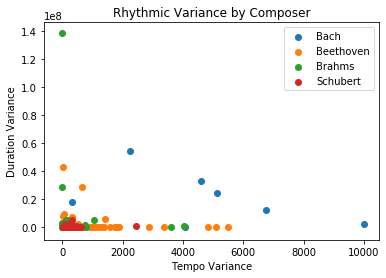

In [8]:
# Group the data by composer
grouped = all_composers.groupby('Composer')

# Plot the rhythmic features by composer
for name, group in grouped:
    plt.scatter(group['Rhythmic Tempo Variance'], group['Rhythmic Duration Variance'], label=name)

plt.title("Rhythmic Variance by Composer")
plt.xlabel("Tempo Variance")
plt.ylabel("Duration Variance")
plt.legend()
plt.show()

In [9]:
all_composers.describe()

,Number of Tracks,Number of Notes,Melodic Range,Melodic Mean,Melodic Variance,Melodic Entropy,Rhythmic Tempo Mean,Rhythmic Tempo Variance,Rhythmic Duration Mean,Rhythmic Duration Variance,Number of Instruments,Layering
count,194.000000,194.000000,194.000000,194.000000,194.000000,0.0,194.000000,194.000000,194.000000,1.940000e+02,194.000000,194.000000
mean,5.613402,4997.731959,59.902062,62.966530,150.055825,NaN,116.425744,629.155370,74.416623,2.523531e+06,1.953608,3.659794
std,4.109893,4194.619542,10.300445,3.462163,47.242503,NaN,60.107534,1296.827455,99.548239,1.179813e+07,1.440679,3.640266
min,2.000000,509.000000,25.000000,52.652174,27.796201,NaN,17.385322,0.000000,6.134034,3.740460e+02,0.000000,1.000000
25%,3.000000,2090.500000,58.000000,61.383959,127.434184,NaN,62.618881,39.118023,23.755230,1.234522e+04,1.000000,2.000000
50%,4.000000,3855.000000,60.000000,63.271760,153.507755,NaN,114.594826,157.170924,42.130997,5.037714e+04,1.000000,2.000000
75%,6.000000,6358.500000,65.000000,64.875079,177.055302,NaN,154.674774,581.210719,82.081835,4.484838e+05,3.000000,4.000000
max,21.000000,22962.000000,77.000000,72.565403,259.817619,NaN,300.000000,10000.000000,858.357775,1.383387e+08,9.000000,17.000000


In [10]:
# Loop over the columns and print the count of null values
for col in all_composers.columns:
    print(f"{col} has {all_composers[col].isna().sum()} null values")

Composer has 0 null values
Filename has 0 null values
Number of Tracks has 0 null values
Number of Notes has 0 null values
Melodic Range has 0 null values
Melodic Mean has 0 null values
Melodic Variance has 0 null values
Melodic Entropy has 194 null values
Tempos has 0 null values
Rhythmic Tempo Mean has 0 null values
Rhythmic Tempo Variance has 0 null values
Rhythmic Duration Mean has 0 null values
Rhythmic Duration Variance has 0 null values
time_signature_changes has 0 null values
key_signature_changes has 0 null values
chord_progressions has 0 null values
Number of Instruments has 0 null values
Type of Instruments has 0 null values
Layering has 0 null values


We want to experiment with making the dictionaries and lists from our data useful. It would be nice to analyze which Instruments are most common among composers and if there is unique key signiture that a composer likes to use often. After further analysis, I found that using the composer name will cause data leakage. Therefore, I will use filename. 

In [11]:
# **Find the most common instruments per file
# group the DataFrame by composer and apply value_counts() to the "Type of Instrument" column
instrument_counts = all_composers.groupby('Composer')['Type of Instruments'].apply(lambda x: pd.Series([i for j in x for i in j]).value_counts())

# get the index of the maximum value for each composer
most_common_instrument = instrument_counts.groupby('Composer').apply(lambda x: x[x == x.max()].index.values)

print(instrument_counts)
print(most_common_instrument)

Composer     
Bach       42     12
           40      8
           41      4
           6       3
Beethoven  0     103
           40     41
           42     28
           41     23
           45     10
           71      9
           70      6
           60      6
           68      4
Brahms     40     15
           42     13
           45     11
           41     11
           0      10
           60      6
           71      5
           73      2
           70      2
           43      2
Schubert   0      21
           42      6
           40      6
           41      5
           43      4
           45      3
Name: Type of Instruments, dtype: int64
Composer
Bach             [(Bach, 42)]
Beethoven    [(Beethoven, 0)]
Brahms         [(Brahms, 40)]
Schubert      [(Schubert, 0)]
Name: Type of Instruments, dtype: object


In [12]:
import pandas as pd

# create an empty DataFrame with the desired columns
df = pd.DataFrame(columns=['Composer', 'Instrument', 'Count'])

# add a new row to the DataFrame
df = df.append({'Composer': 'Bach', 'Instrument': 'Viola', 'Count': 12}, ignore_index=True)
# add rows for Beethoven, Brahms, and Schubert
df = df.append({'Composer': 'Beethoven', 'Instrument': 'Acoustic Grand Piano', 'Count': 103}, ignore_index=True)
df = df.append({'Composer': 'Brahms', 'Instrument': 'Violin', 'Count': 15}, ignore_index=True)
df = df.append({'Composer': 'Schubert', 'Instrument': 'Acoustic Grand Piano', 'Count': 21}, ignore_index=True)

# print the DataFrame
print(df)

    Composer            Instrument Count
0       Bach                 Viola    12
1  Beethoven  Acoustic Grand Piano   103
2     Brahms                Violin    15
3   Schubert  Acoustic Grand Piano    21


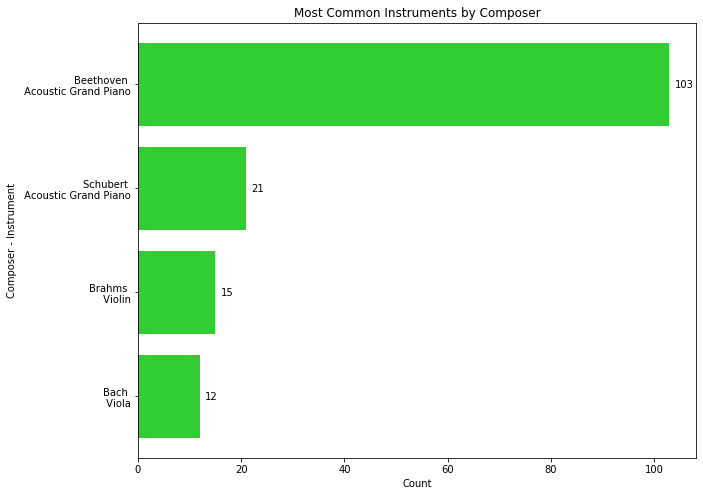

In [17]:
import matplotlib.pyplot as plt

# sort the DataFrame by Count in descending order
df = df.sort_values(by='Count', ascending=True)

# create the bar chart
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(df['Composer'] + ' \n ' + df['Instrument'], df['Count'], color='limegreen')

# add labels to the bars
for bar in bars:
    width = bar.get_width()
    label = '{:,}'.format(int(width))
    ax.text(width + 1, bar.get_y() + bar.get_height()/2, label, ha='left', va='center')

# set the axis labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Composer - Instrument')
ax.set_title('Most Common Instruments by Composer')

plt.show()

In [ ]:
# # convert sets to tuples in 'Type of Instruments' column
# all_composers['Type of Instruments'] = all_composers['Type of Instruments'].apply(lambda x: tuple(x))

# # create a bar chart of the most common instrument played by each composer
# most_common_instrument = all_composers.groupby('Composer')['Type of Instruments'].value_counts().groupby('Composer').head(1)
# most_common_instrument.sort_values().plot(kind='barh', figsize=(10,6), color='limegreen')

# # customize the plot
# plt.title('Most Common Instrument Played by Each Composer')
# plt.xlabel('Number of Occurrences')
# plt.ylabel('Composer')

# # add labels to the bars
# for i, v in enumerate(most_common_instrument.sort_values()):
#     plt.text(v + 0.2, i - 0.1, str(v), color='black')
# plt.show()

Most Common Instrument seems to vary among our Composers. Bach Beethoven and Brahms seem to have different favorites when it comes to an Instrument. Schubert and Beethoven favor the same instrument.We can use this variable as a Categorical Variable for our Model. (Note since this feature is already numeric and maps to a specfic instrument we do not need to perform label encoding). After further analysis, key_signiture change was removed from the model since it causes data leakage. 

In [ ]:
# # create a new DataFrame with the Composer and Most Common Instrument columns
# most_common_df = pd.DataFrame({
#     'Filename': most_common_instrument.index,
#     'Most Common Instrument': [val[0][1] for val in most_common_instrument.values]
# })
# most_common_df

# # merge the new DataFrame with all_composers
# all_composers = all_composers.merge(most_common_df, on='Composer')

In [ ]:
# *Column key signature changes - find the number of distinct key signatures per composer
# create a new DataFrame with only the 'Composer' and 'Key Signature' columns
key_sig_df = all_composers[['Composer', 'key_signature_changes']]

# convert key_signature_changes column to tuples
key_sig_df['key_signature_changes'] = key_sig_df['key_signature_changes'].apply(tuple)

# group the DataFrame by 'Composer' and count the number of unique key signatures
num_key_sigs = key_sig_df.groupby('Composer')['key_signature_changes'].nunique().reset_index(name='Num Distinct Key Sigs')

# sort the DataFrame by the number of unique key signatures in descending order
num_key_sigs = num_key_sigs.sort_values('Num Distinct Key Sigs', ascending=False)

# print the composers with the most distinct key signatures
num_key_sigs

The number of unique key signures seem to drastically vary among our composers. Beethoven seems to have many unique key signitures while Bach only has a few.

In [ ]:
# merge the new key signiture field with all_composers
all_composers = all_composers.merge(num_key_sigs, on='Composer')

In [ ]:
# create a new dataframe with the count of rows by composer
composer_counts = all_composers['Composer'].value_counts().reset_index()
composer_counts.columns = ['Composer', 'Count']

# calculate the avg number of tracks for each composer
num_tracks = all_composers.groupby('Composer')['Number of Tracks'].mean().reset_index()
num_tracks.columns = ['Composer', 'Number of Tracks']

# merge the two dataframes
df = pd.merge(composer_counts, num_tracks, on='Composer')

# calculate the count of rows per track
df['Count per Track'] = df['Count'] / df['Number of Tracks']
df

# merge the new field with all_composers
all_composers = all_composers.merge(df[['Composer','Count per Track']], on='Composer')
all_composers.head()

In [ ]:
# group by composer and calculate mean num_notes
grouped = all_composers.groupby('Composer')['Layering'].mean()

# sort values in descending order
grouped = grouped.sort_values(ascending=True)

# create a bar chart
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(grouped.index, grouped.values, color='limegreen')

# add axis labels and title
# ax.set_xlabel('Average Layering')
# ax.set_ylabel('Composer')
# ax.set_title('Average Layering by Composer')

# add labels for the means
for i, v in enumerate(grouped.values):
    ax.text(v + 0.2, i-0.1, str(round(v, 2)), color='black')

ax.set_xlim([0, 11])

# show the chart
plt.show()

In [ ]:
df = all_composers[['Composer', 'Melodic Range']]

# create box plot of melodic ranges by composer
grouped = all_composers.groupby('Composer')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# add padding to subplot layout
plt.subplots_adjust(hspace=0.3)

for (composer, group), ax in zip(grouped, axes.flatten()):
    group.boxplot(column='Melodic Range', ax=ax)
    ax.set_title(composer)
#     ax.set_xlabel(composer)
    ax.set_ylabel('Melodic Range')
    
plt.show()

In [ ]:
# group by composer and calculate mean num_notes
grouped = all_composers.groupby('Composer')['Number of Notes'].mean()

# plot bar graph
grouped.plot(kind='bar', color='limegreen')
plt.xlabel('Composer')
plt.ylabel('Average Number of Notes')
plt.title('Average Number of Notes by Composer')
plt.show()

In [ ]:
# # create a bar plot of the count of rows per track by composer
# df.plot(x='Composer', y='Count per Track', kind='bar')

# # set the title and axis labels
# plt.title('Count of Rows per Track by Composer')
# plt.xlabel('Composer')
# plt.ylabel('Count per Track')

# # show the plot
# plt.show()

This tells us that Beethoven has usally has many tracks in his midi files. This can be useful for the model to determine if a midi file is created by a particular composer or not. 

In [ ]:
# create a histogram of the 'Number of notes' column for the Beethoven data
beethoven_df['Number of Notes'].hist()

# set the title and axis labels
plt.title('Histogram of Number of Notes for Beethoven')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')

# show the plot
plt.show()

In [ ]:
# create a histogram of the 'Number of Tracks' column for the Brahms data
brahms_df['Number of Notes'].hist()

# set the title and axis labels
plt.title('Histogram of Number of Notes for Brahms')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')

# show the plot
plt.show()

In [ ]:
# create a histogram of the 'Number of Tracks' column for the Bach data
bach_df['Number of Notes'].hist()

# set the title and axis labels
plt.title('Histogram of Number of Notes for Bach')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')

# show the plot
plt.show()

In [ ]:
# create a histogram of the 'Number of Tracks' column for the Brahms data
schubert_df['Number of Notes'].hist()

# set the title and axis labels
plt.title('Histogram of Number of Notes for Schubert')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')

# show the plot
plt.show()

Her we are analyzing the distrubtion of Notes for each Composer to see if there are any major outlier in our data. Seems like Beethoven and Schubert have some outliers that should be removed from the data. 

In [ ]:
sns.set(style='ticks')

# Select only the numeric columns
numeric_cols = ['Number of Tracks','Number of Notes', 'Layering','Most Common Instrument',
                'Num Distinct Key Sigs','Count per Track', 'Melodic Range', 'Rhythmic Tempo Mean']
df_num = all_composers[numeric_cols]

# Compute the correlation matrix
corr = df_num.corr()

# Plot the correlation matrix
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Add histograms along the diagonal
g = sns.PairGrid(df_num)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.show()

We plot the correlation matrix along with the pair grid to determine if any of our variables are multi correlated. It seems Layering & Number of Tracks are highly correlated as well as Num Distinct Key Sigs & Count per Track. We should not use one or the other of these variables. Layering and Number of Unique Key Signitures seem to give us features directly related to music so we will use these. 

# Feature Selection

These are the final set of features for our modeling after experimentation and analysis. This allows the notebook to to run end to end. Below are a few notes on how features were selected and removed. 
  * Some of the features explored in EDA create data leakage so they should not be used for modeling. 
  * Multicollinear feature pairs were removed. 
  * Random Forrest Feature Importance was used to remove the least important features. 
  
Standard Train/Test Split of 80/20 was used. 70/30 and 75/25 were also tested but due to a low row count 80/20 worked best. 

In [ ]:
X = all_composers[['Number of Notes','Melodic Range','Melodic Variance','Rhythmic Duration Variance', 'Layering',
                   'Most Common Instrument']]

y = all_composers['Composer']

# Train/Test Split

In [ ]:
# X and y are your feature matrix and label vector, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection

4 models were used for experimentation. Below are some pros and cons of each. 

Logistic Regression:
Pros: Simple, interpretable, efficient, handles both binary and multiclass problems.
Cons: Linear, may not capture complex relationships, assumes linear relationship between features and target.

Random Forest:
Pros: Non-linear, robust, handles both numerical and categorical features, handles both binary and multiclass problems.
Cons: Slow for large datasets, prone to overfitting, difficult to interpret.

Naive Bayes:
Pros: Simple, efficient, handles both binary and multiclass problems, handles missing data.
Cons: Assumes conditional independence between features, may not perform well with irrelevant features or imbalanced classes, difficult to interpret.

XGBoost:
Pros: Non-linear, handles both numerical and categorical features, handles both binary and multiclass problems, regularization techniques to prevent overfitting.
Cons: Slow for large datasets, difficult to interpret, may require more hyperparameter tuning. 

For a multiclass classification problem and an imbalanced dataset, random forrest or xgboost may perform best

In [ ]:
# Define models and their hyperparameters
models = {'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier(),
          'Naive Bayes': GaussianNB(), 
          'XGBoost': XGBClassifier()}

# Train models, make predictions, and evaluate performance
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report['weighted avg']

# Convert results dictionary to a pandas DataFrame
df = pd.DataFrame(results)
df

Random Forrest shows the best precison and recall here. Precsion and Recall are important metrics for classfication:

Precision: Percentage of correct positive predictions relative to total positive predictions.
Recall: Percentage of correct positive predictions relative to total actual positives.

We will use grid search to tune the hyperparmeters of our best model. 

# Model Training

In [ ]:
# Implement Grid Search on Best Model to tune hyper parameters
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Create a random forest classifier
rf = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found by the grid search
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best hyperparameters:", best_params)

# Create a new Random Forest classifier with the best hyperparameters
rf_best = RandomForestClassifier(**best_params)

# Train the classifier on the training data
rf_best.fit(X_train, y_train)

# Use the classifier to make predictions on the test data
y_pred = rf_best.predict(X_test)

In [ ]:
# Get the feature importances and sort them in descending order
importances = rf_best.feature_importances_
sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]

# Create a horizontal bar chart
plt.barh(range(len(importances)), sorted_importances)

# Customize the plot
plt.yticks(range(len(importances)), X.columns[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')

# Display the plot
plt.show()

# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report
# Print the classification report
print(classification_report(y_test, y_pred))

This is a classification report that evaluates the performance of a model on a multi-class classification task. It shows the precision, recall, F1-score, and support (number of samples) for each class, as well as the overall accuracy, macro average, and weighted average across all classes.

The report suggests that the model performs very well with an accuracy of 0.95. The Bach class has perfect precision, recall, and F1-score, indicating that all Bach samples are correctly classified. Beethoven class has high precision, recall, and F1-score, while Brahms and Schubert have lower scores due to lower support. The macro average and weighted average of the F1-score are 0.88 and 0.93 respectively, indicating a good overall performance of the model.

# Infercence on PS2 Data

In [ ]:
test_df = read_mido_files(composer = 'TBD', path = "/Users/rachit/Downloads/Part One Data/Part1(PS2)")

In [ ]:
test_df.head()

Here we want to test our model on live (PS2) data. To do this we first need to create the same features we have in our training data and train the best model on PS2 data. 

In [ ]:
# **Find the most common instruments per file
# group the DataFrame by composer and apply value_counts() to the "Type of Instrument" column
instrument_counts = test_df.groupby('Filename')['Type of Instruments'].apply(lambda x: pd.Series([i for j in x for i in j]).value_counts())

# get the index of the maximum value for each composer
most_common_instrument = instrument_counts.groupby('Filename').apply(lambda x: x[x == x.max()].index.values)

In [ ]:
# create a new DataFrame with the Composer and Most Common Instrument columns
most_common_df = pd.DataFrame({
    'Filename': most_common_instrument.index,
    'Most Common Instrument': [val[0][1] for val in most_common_instrument.values]
})
most_common_df

# merge the new DataFrame with all_composers
test_df = test_df.merge(most_common_df, on='Filename')

In [ ]:
# select same features as we did in our model training for our test data
X_test = test_df[['Number of Notes','Melodic Range','Melodic Variance','Rhythmic Duration Variance',
                  'Layering','Most Common Instrument']]

In [ ]:
# Use the classifier to make predictions on the test data
proba = rf_best.predict_proba(X_test)

# Get the class labels from the classifier
classes = rf_best.classes_

# Create a DataFrame with the predicted probabilities and their corresponding class labels
df_proba_y_pred = pd.DataFrame(proba, columns=classes)

The goal of this project was to identify which midi files in the PS2 dataset were not composed by Bach, Brahms, Beethoven, and Schubert. To accomplish this, we required the ML classifier to provide a probability score for each midi file indicating the likelihood of it being composed by a specific artist. To determine the midi files that were not composed by any of these four artists, we had to establish a threshold for classification as "Other".

Given the client's instructions (document), which stated that only a small percentage of the midi files in PS2 were not composed by Bach, Brahms, Beethoven, or Schubert, we plotted the count of "Other" classifications against the thresholds to determine the optimal threshold value. Based on the plot and common classfication theory, the threshold was chosen to be 0.50.

In [ ]:
import numpy as np
# Define the range of thresholds to test
thresholds = np.linspace(0.25, 1.0, num=20)

# Create an empty list to store the number of other composers for each threshold
other_counts = []

# Loop through each threshold
for threshold in thresholds:
    # Create a new column in the DataFrame to indicate whether each sample is classified as other or not
    df_proba_y_pred['other'] = df_proba_y_pred.apply(lambda row: 1 if all(prob < threshold for prob in row.values) else 0, axis=1)
    
    # Count the number of samples classified as other
    other_count = df_proba_y_pred['other'].sum()
    
    # Append the count to the list
    other_counts.append(other_count)

# Plot the results
plt.plot(thresholds, other_counts)
plt.xlabel('Threshold')
plt.ylabel('Number of Other Composers')
plt.show()

In [ ]:
# Drop the 'other' column from the DataFrame
df = df_proba_y_pred.drop('other', axis=1)

# Create an empty list to store the indexes of non-Bach/Brahms/Beethoven/Schubert compositions
other_composers = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    # Check if any probability score in the row is greater than or equal to 0.50
    if not any(prob >= 0.50 for prob in row):
        # If not, append the index to the list of non-Bach/Brahms/Beethoven/Schubert compositions
        other_composers.append(index)
        # Print the index (optional, for debugging purposes)
        print(index)

In [ ]:
final_df = pd.merge(test_df[['Filename']], df_proba_y_pred, left_index=True, right_index=True)

Conclusion: The final output below shows these are the 2 files which were not composed by by Bach, Brahms, Beethoven, or Schubert

In [ ]:
not_composers_df = final_df.loc[other_composers]
not_composers_df[['Filename']]